<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🚸Traffic 🚦Sign Recognition⛔with YOLOV8🚥 KERASCV🚸**

[Traffic🚥Signs🚦⛔Dataset🚸](https://www.kaggle.com/datasets/emmermarcell/traffic-signs-data-challenge)

[Traffic Signs Dataset](https://www.kaggle.com/datasets/emmermarcell/mapillary-labels)

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/emmermarcell/mapillary-labels/mapillary-labels.zip

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/emmermarcell/traffic-signs-data-challenge/traffic-signs-data-challenge.zip

In [6]:
!rm -rf /content/https:

In [ ]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras  # Upgrade to Keras 3.
!pip install -U pycocotools    # Official APIs for the MS-COCO dataset, the backbone of our model i.e. the dataset it was trained on

In [8]:
# List the versions of keras for reproducibility
!pip list | grep tensorflow
!pip list | grep keras

tensorflow                       2.16.1
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.15.0
tensorflow-probability           0.23.0
keras                            3.3.3
keras-core                       0.1.7
keras-cv                         0.9.0
tf_keras                         2.15.1


In [3]:
import keras_cv
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from keras_cv import bounding_box, visualization

from pprint import pprint

In [11]:
# Set jax backend for keras
os.environ["KERAS_BACKEND"] = "jax"

# Set CUDA visible devices to GPU 0 (The T100 GPU that Kaggle provides)
os.environ["CUDA_VISIBLE_DEVICES"]="0"


##**There are 6 traffic sign categories your model should be able to recognize:**

- Category A - no right, left, or U-turn
- Category B - speed limit (regardless of the indicated value)
- Category C - road closed
- Category D - no entry
- Category E - no stopping, no parking
- Category F - other types of prohibitory traffic signs

In [12]:
# Track hyperparameters
config = {
        # Random seed
        "seed": 42,
        # For loading in the images
        "num_classes": 6,
        "image_size": 160,
        "image_channels": 3,
        "batch_size": 4,
        "bbox_format": "xyxy",
        # Size of the training set (max is 26714), set to 'all' if you need all
        "train_size": 1_000,
        # Size of the validation set (max is 922), set to 'all' if you need all
        "val_size": 100,
        # For the prediction decoder
        "iou_threshold": 0.5,
        "confidence_threshold": 0.75,
        # For the Adam optimizer
        "learning_rate": 0.001,
        "global_clipnorm": 10.0,
        # For freezing layers (max is 169 for yolo_v8_s_backbone_coco)
        'freeze_layers': 125,
        # For evaluating the BoxCOCOMetrics
        'eval_freq': 1e9,
        # For fitting the model
        "checkpoint_path": 'yolo-traffic-sign.keras',
        "num_epochs": 20,
        "early_stopping_patience": 5,
        "log_frequency": 5,
}


# Set the random seed for reproducibility
keras.utils.set_random_seed(seed=config['seed'])

In [13]:
img_dir = "/content/train"
#os.listdir(img_dir)

class_ids = [
    'no-right-left-or-u-turn',
    'speed-limit',
    'road-closed',
    'no-entry',
    'no-stopping-no-parking',
    'other'
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'no-right-left-or-u-turn',
 1: 'speed-limit',
 2: 'road-closed',
 3: 'no-entry',
 4: 'no-stopping-no-parking',
 5: 'other'}

In [14]:
annot_file = "/content/train/_annotations.csv"
annot_df = pd.read_csv(annot_file)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-entry,22,149,60,177
1,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-stopping-no-parking,520,160,570,198
2,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,other,522,236,571,274
3,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,road-closed,506,121,542,153
4,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,other,555,97,597,131


In [15]:
# Group the annotations by filename and aggregate the class ids into a list
test_df = annot_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg,"[600, 600, 600]","[300, 300, 300]","[road-closed, no-stopping-no-parking, speed-li...","[211, 515, 515]","[175, 107, 68]","[240, 557, 555]","[203, 143, 104]"
1,11_jpg.rf.788b737ab908f716125157158a741b1d.jpg,"[600, 600]","[300, 300]","[no-stopping-no-parking, no-entry]","[543, 6]","[67, 112]","[600, 42]","[142, 146]"
2,12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg,"[600, 600]","[300, 300]","[speed-limit, no-stopping-no-parking]","[521, 524]","[147, 186]","[556, 556]","[177, 214]"
3,13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg,"[600, 600, 600]","[300, 300, 300]","[speed-limit, other, no-stopping-no-parking]","[431, 432, 430]","[149, 120, 91]","[459, 460, 460]","[176, 149, 120]"
4,14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg,"[600, 600, 600]","[300, 300, 300]","[other, other, speed-limit]","[463, 456, 319]","[104, 158, 124]","[487, 496, 327]","[158, 213, 134]"


In [16]:
def prepare_df(df, img_dir):
    img_name = df["filename"]
    img_path = os.path.join(img_dir, img_name)

    x_min = df["xmin"]
    y_min = df["ymin"]
    x_max = df["xmax"]
    y_max = df["ymax"]

    boxes = [[x_min[i], y_min[i], x_max[i], y_max[i]] for i in range(len(x_min))]

    classes = df["class"]
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes]
   # class_ids = [class_ids]

    return img_path, boxes, class_ids

In [17]:
def df_to_tensor(df, img_dir):
    img_paths = []
    bboxes = []
    classes = []
    for idx, rows in df.iterrows():
        img_path, boxes, class_ids = prepare_df(rows, img_dir)
        img_paths.append(img_path)
        bboxes.append(boxes)
        classes.append(class_ids)

    print('image_paths first 10')
    pprint(img_paths[:10])
    print('bbox first 10')
    pprint(bboxes[:10])
    print('classes first 10')
    pprint(classes[:10])


    bboxes = tf.ragged.constant(bboxes)
    classes = tf.ragged.constant(classes)
    img_paths = tf.ragged.constant(img_paths)
    print(bboxes.shape)

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, classes, bboxes))
    return dataset

In [18]:
print("Test data...")
test_data = df_to_tensor(test_df, img_dir)

Test data...
image_paths first 10
['/content/train/10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg',
 '/content/train/11_jpg.rf.788b737ab908f716125157158a741b1d.jpg',
 '/content/train/12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg',
 '/content/train/13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg',
 '/content/train/14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg',
 '/content/train/15_jpg.rf.162c7db1dc3d488435d85966979936da.jpg',
 '/content/train/16_jpg.rf.12b7ef37dd31287b55ace3deb5eaf975.jpg',
 '/content/train/17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg',
 '/content/train/18_jpg.rf.7f567daed1f036392e4c88d133258cb1.jpg',
 '/content/train/19_jpg.rf.b5ae2cd88323133d231664b6bc9a6a6b.jpg']
bbox first 10
[[[211, 175, 240, 203], [515, 107, 557, 143], [515, 68, 555, 104]],
 [[543, 67, 600, 142], [6, 112, 42, 146]],
 [[521, 147, 556, 177], [524, 186, 556, 214]],
 [[431, 149, 459, 176], [432, 120, 460, 149], [430, 91, 460, 120]],
 [[463, 104, 487, 158], [456, 158, 496, 213], [319, 124, 327, 134]

###**Prepare Data for Traing and Validation**

In [19]:
train_img_dir = "/content/images/images"
train_annot_dir = "/content/object_all.csv"

train_annot_df = pd.read_csv(train_annot_dir)
#train_annot_df.head()
train_annot_df = train_annot_df.drop(["Unnamed: 0"], axis = 1)
train_annot_df.rename(columns = {"name" : "filename"}, inplace = True)
train_annot_df.replace(to_replace=r'_aug', value='_augreduced', regex=True, inplace=True)
train_annot_df["filename"] = train_annot_df["filename"] + ".jpg"

train_annot_df[['xmin', 'ymin', 'xmax', 'ymax']] = train_annot_df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)


train_annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,hzlM917YtiazVQzFBL8kCw_3819_augreduced.jpg,4032,3024,road-closed,621,2752,679,2845
1,HcYl32I27DcQPFISMtgacw_3748_augreduced.jpg,4032,3024,road-closed,2968,1259,3124,1416
2,5EMpP9GmwHDBQz8YcZ3_oQ_2289_augreduced.jpg,4032,3024,road-closed,2231,993,2404,1159
3,9wyk0xrm1mdAu3C3GbVlqQ_2500_augreduced.jpg,3264,2448,road-closed,2331,1849,2477,1988
4,zUfI8ZBn02wK2VTzv6GgvQ_2240_augreduced.jpg,5248,3936,road-closed,3731,953,3781,1019


In [20]:
train_annot_df = train_annot_df.groupby(["filename"]).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()
train_annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,--7fWq6WjZM8L1eUSuvOEA.jpg,[4160],[3120],[other],[1480],[1327],[1576],[1421]
1,--7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg,[4160],[3120],[other],[1334],[1302],[1427],[1382]
2,--7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg,[4160],[3120],[other],[2215],[1044],[2330],[1149]
3,-0G6gt8ksR0hO5jMKrTDMw.jpg,[4032],[3024],[no-entry],[1776],[1932],[1800],[1956]
4,-0oqTZyDwf6SJlJXaHSTVg.jpg,[3840],[2160],[no-entry],[1267],[890],[1305],[951]


In [21]:
val_img_path = "/content/validation.txt"

with open(val_img_path, "r") as file:
    valid_file = [line.strip() + ".jpg" for line in file]

valid_df = train_annot_df[train_annot_df["filename"].isin(valid_file)]
train_df = train_annot_df[~train_annot_df["filename"].isin(valid_file)]

In [22]:
valid_df.shape, train_df.shape

((922, 8), (26714, 8))

In [23]:
train_df.info()
print("=="*20)
test_df.info()
print("=="*20)
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26714 entries, 0 to 27635
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  26714 non-null  object
 1   width     26714 non-null  object
 2   height    26714 non-null  object
 3   class     26714 non-null  object
 4   xmin      26714 non-null  object
 5   ymin      26714 non-null  object
 6   xmax      26714 non-null  object
 7   ymax      26714 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  20 non-null     object
 1   width     20 non-null     object
 2   height    20 non-null     object
 3   class     20 non-null     object
 4   xmin      20 non-null     object
 5   ymin      20 non-null     object
 6   xmax      20 non-null     object
 7   ymax      20 non-null     ob

In [24]:
print("Train Data....")

# Check if we use all of the training images
if config['train_size'] == 'all':
    train_data = df_to_tensor(train_df, train_img_dir)

# If not then use the fist n that are less than all the training images
elif isinstance(config['train_size'], int) and config['train_size'] <= len(train_df):
    train_data = df_to_tensor(train_df.head(config['train_size']), train_img_dir)

    # The size of the training set can be changed in  the config (max is 26714)
else:
    raise ValueError('Size of the training set inside the config is invalid.')



print("Validation Data....")

# Check if we use all of the validation images
if config['val_size'] == 'all':
    valid_data = df_to_tensor(valid_df, train_img_dir)

# If not then use the fist n that are less than all the training images
elif isinstance(config['val_size'], int) and config['val_size'] <= len(valid_df):
    valid_data = df_to_tensor(valid_df.head(config['val_size']), train_img_dir)

    # The size of the training set can be changed in  the config (max is 26714)
else:
    raise ValueError('Size of the validation set inside the config is invalid.')

Train Data....
image_paths first 10
['/content/images/images/--7fWq6WjZM8L1eUSuvOEA.jpg',
 '/content/images/images/--7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg',
 '/content/images/images/--7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg',
 '/content/images/images/-0G6gt8ksR0hO5jMKrTDMw.jpg',
 '/content/images/images/-0oqTZyDwf6SJlJXaHSTVg.jpg',
 '/content/images/images/-0oqTZyDwf6SJlJXaHSTVg_1629_augreduced.jpg',
 '/content/images/images/-0oqTZyDwf6SJlJXaHSTVg_188_augreduced.jpg',
 '/content/images/images/-0oqTZyDwf6SJlJXaHSTVg_3070_augreduced.jpg',
 '/content/images/images/-1dYvHaY52PTrihdjPDPQg.jpg',
 '/content/images/images/-1dYvHaY52PTrihdjPDPQg_1943_augreduced.jpg']
bbox first 10
[[[1480, 1327, 1576, 1421]],
 [[1334, 1302, 1427, 1382]],
 [[2215, 1044, 2330, 1149]],
 [[1776, 1932, 1800, 1956]],
 [[1267, 890, 1305, 951]],
 [[2139, 1223, 2177, 1287]],
 [[2296, 1140, 2335, 1206]],
 [[1914, 701, 1965, 756]],
 [[2217, 2313, 2403, 2546], [5009, 1851, 5246, 2191]],
 [[3132, 2691, 3340, 2925]]]
clas

In [25]:
def load_img(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image

def load_dataset(img_paths, classes, bboxes):
    print("bbox....", bboxes)
    print("bbox shape ::", bboxes.shape)

    image = load_img(img_paths)
    bboxes = {
        "classes" : tf.cast(classes, dtype = tf.float32),
        "boxes" : bboxes
        }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bboxes}

In [26]:
# Create an augmenter using the KerasCV layers for the training set
augmenter = keras.Sequential(
    layers=[
        # Randomly flip the image horizontally
        keras_cv.layers.RandomFlip(
            mode="horizontal", bounding_box_format=config["bbox_format"]
        ),
        # Randomly shear the image
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=config["bbox_format"]
        ),
        # Randomly zoom into the image
        keras_cv.layers.JitteredResize(
            target_size=(config['image_size'], config['image_size']),
            scale_factor=(0.75, 1.3), bounding_box_format=config["bbox_format"]
        ),
    ]
)

# Create a resizer layer for the validation and test sets
# Source: https://keras.io/api/keras_cv/layers/preprocessing/resizing/
resizer = keras_cv.layers.Resizing(
    height=config['image_size'],
    width=config['image_size'],
    pad_to_aspect_ratio=True,
    bounding_box_format=config["bbox_format"],
)

# This layer implements resize with scale distortion
# Source: https://keras.io/api/keras_cv/layers/augmentation/jittered_resize/
jittered_resizer = keras_cv.layers.JitteredResize(
    target_size=(config['image_size'], config['image_size']),
    scale_factor=(0.75, 1.3),
    bounding_box_format=config["bbox_format"],
)

In [27]:
def preprocess_data(dataset, augmentation):
    dataset = dataset.map(load_dataset, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(config["batch_size"] * 4)
    dataset = dataset.ragged_batch(config["batch_size"], drop_remainder = True)
    dataset = dataset.map(augmentation,  num_parallel_calls = tf.data.AUTOTUNE)
    return dataset

In [28]:
train_dataset = preprocess_data(train_data, resizer)
valid_dataset = preprocess_data(valid_data, resizer)
test_dataset = preprocess_data(test_data, resizer)

bbox.... tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape :: (None, None)
bbox.... tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape :: (None, None)
bbox.... tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))
bbox shape :: (None, None)


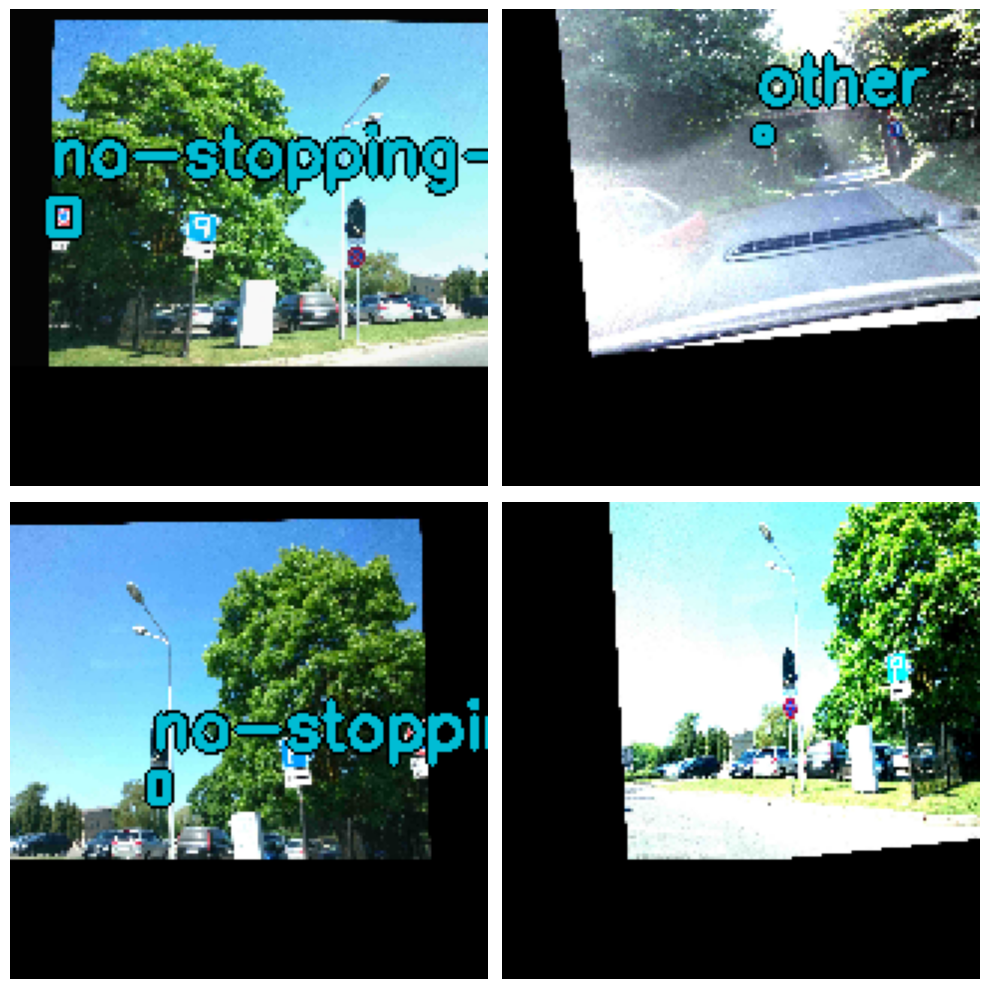

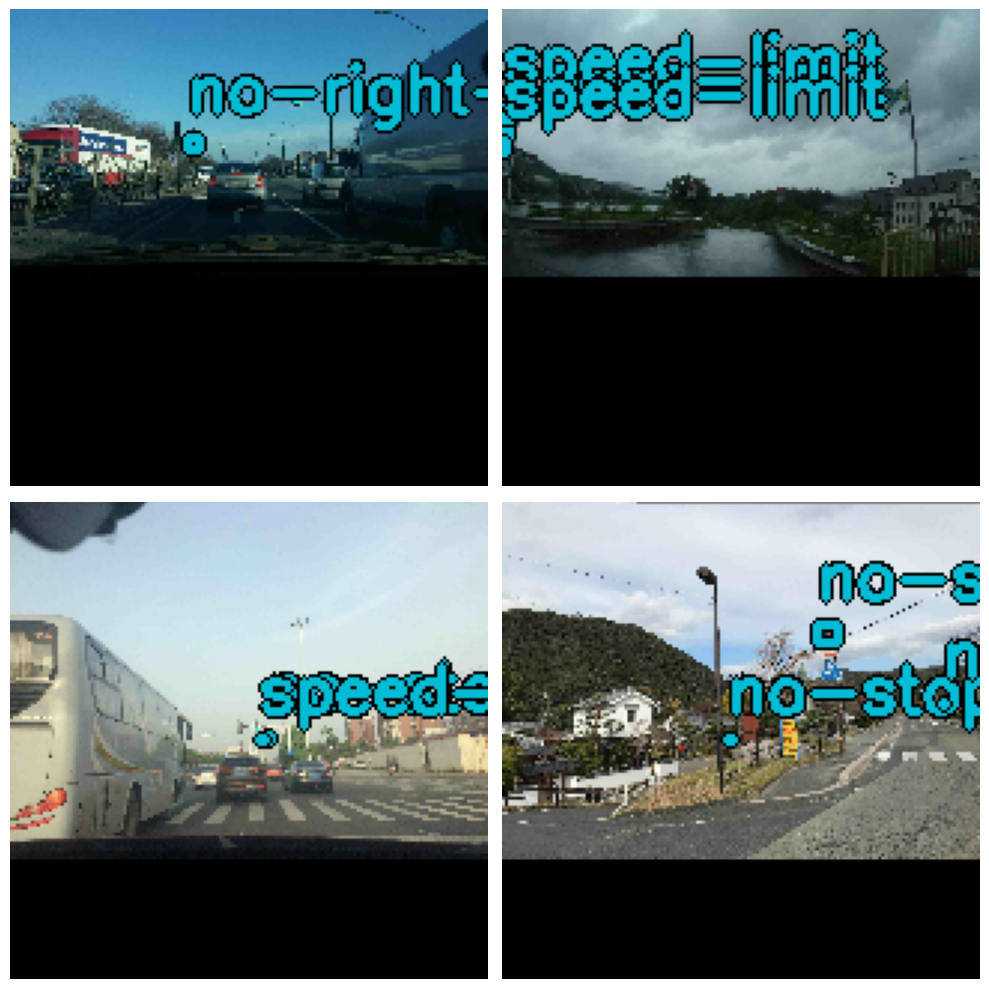

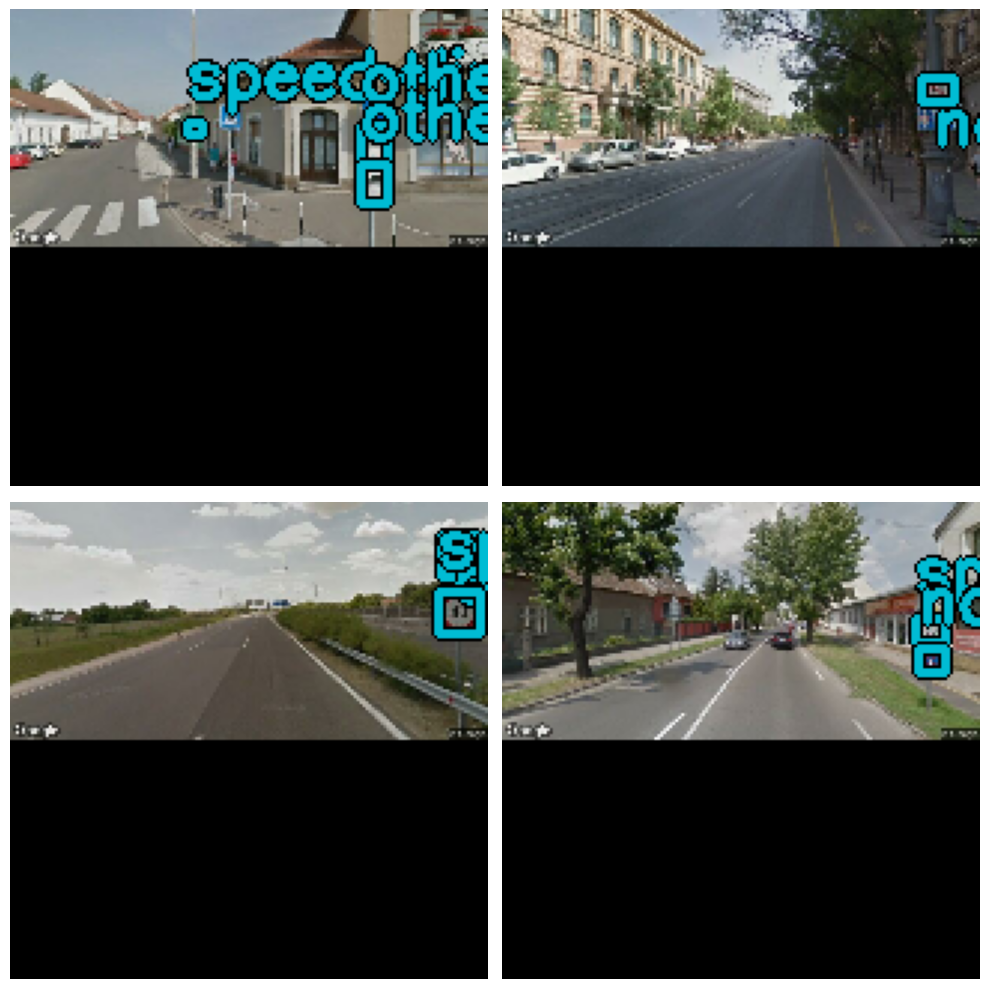

In [29]:
def visualize_dataset(dataset, value_range, rows, cols, bounding_box_format):

    dataset = next(iter(dataset.take(1)))
    images, bounding_boxes = dataset["images"], dataset["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    train_dataset,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

visualize_dataset(
    valid_dataset,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

visualize_dataset(
    test_dataset,
    bounding_box_format=config["bbox_format"],
    value_range=(0, 255),
    rows=2, cols=2
)

In [30]:
def dict_to_tuple(dataset):
    """
    Function to convert the dictionary to a tuple
    :param inputs: Dictionary
    :return: Tuple containing the image and bounding boxes
    """
    return dataset["images"], bounding_box.to_dense(dataset["bounding_boxes"], max_boxes = 32)

In [31]:
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [32]:
def build_model():
    """
    Builds the yolo model from the yolo_v8_s_coco backbone
    :return: yolo model with the first 150 layers frozen
    """
    prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format=config["bbox_format"],
        from_logits=True,
        # Decrease the required threshold to make predictions get pruned out
        iou_threshold=config['iou_threshold'],
        # Tune confidence threshold for predictions to pass NMS
        confidence_threshold=config['confidence_threshold'],
    )

    # For transfer learning, we load the YOLOv8 weights trained on the COCO dataset
    yolo = keras_cv.models.YOLOV8Detector.from_preset(
        preset="yolo_v8_s_backbone_coco",    # A small YOLOV8 backbone with 5.09 million parameters. Ref: https://keras.io/api/keras_cv/models/backbones/yolo_v8/
        num_classes=config['num_classes'],    # The number of neurons in the last layer
        bounding_box_format=config["bbox_format"],
        prediction_decoder=prediction_decoder,
        fpn_depth=1,
    )

    optimizer = keras.optimizers.Adam(
        learning_rate=config['learning_rate'],
        global_clipnorm=config['global_clipnorm'],
    )

    # Freeze the first layers out of the 145
    for layer in yolo.layers[:config['freeze_layers']]:
        layer.trainable=False

    yolo.compile(
        optimizer=optimizer,
        classification_loss="binary_crossentropy",
        box_loss="ciou",
    )    # User metrics is not supported yet for yolov8 so we have to use a callback for it
    # This mean that we can just write e.g.  metrics=['acccuracy'], inside the compile call

    return yolo

In [33]:
yolo_model = build_model()

yolo_model.summary()

100%|██████████| 646/646 [00:00<00:00, 342kB/s]
100%|██████████| 19.7M/19.7M [00:00<00:00, 24.7MB/s]


Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ [(None, None, None,    │      5,089,760 │ input_layer_1[0][0]    │
│                           │ 128), (None, None,     │                │                        │
│                           │ None, 256), (None,     │                │                        │
│                           │ None, None, 512)]      │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat (Repeat)           │ (None, None, None,     │              0 │ functional_1[0][2]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_1 (Repeat)         │ (None, None, None,     │              0 │ repeat[0][0]           │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ repeat_1[0][0],        │
│ (Concatenate)             │ 768)                   │                │ functional_1[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │        196,608 │ concatenate_5[0][0]    │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          1,024 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 128), (None, None,     │                │                        │
│                           │ None, 128)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │        147,456 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │            512 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├──────────────────────

 Total params: 12,799,410 (48.83 MB)

 Trainable params: 14,930 (58.32 KB)

 Non-trainable params: 12,784,480 (48.77 MB)

##**Implement Callbacks**
###**PyCOCOCallback**
We will be using PyCOCOCallback from KerasCV to evaluate the model and calculate the Map(Mean Average Precision) score, Recall and Precision. We also save our model when the mAP score improves.

[Source](https://keras.io/guides/keras_cv/object_detection_keras_cv/)

In [ ]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    valid_dataset,
    bounding_box_format=config["bbox_format"],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=config['early_stopping_patience'],
    verbose=1
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=config["checkpoint_path"],
    save_best_only=True,
    verbose=1
)

callbacks = [coco_metrics_callback, early_stopping, model_checkpoint]

In [ ]:
yolo_model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = config["num_epochs"],
    callbacks = callbacks)

In [ ]:
test_dataset = test_dataset.unbatch()
test_dataset = test_dataset.ragged_batch(len(test_df))

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=5,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(
    yolo_model,
    dataset=test_dataset,
    bounding_box_format=config["bbox_format"]
)

###**Evaluation on the Test set**

In [ ]:
# only consider boxes with areas less than a 128x128 square.
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format=config["bbox_format"],
    evaluate_freq=config['eval_freq'],
)

# Evaluate the model on the test set
test_images, y_true = next(iter(test_dataset.take(1)))
y_pred = yolo_model.predict(test_images)        # Predict the bounding boxes

coco_metrics.update_state(y_true, y_pred) # Update the state of the metric
results = coco_metrics.result(force=True) # Get the results of the metric
results

In [ ]:
results['MaP'].numpy()

In [ ]:
# log the evaluationm metrics
for key, value in results.items():
    run.log({'test_'+key: value.numpy()})

# Close the W&B run
run.finish()